In [1]:
from imports import *
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
import dr2stars
from uncertainties import unumpy as unp
from RVFollowupCalculator import *
from setupRVFCinput import *
import pandas as pd
from IPython.display import display
from gaussian_kde import gaussian_kde
%matplotlib inline

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [16]:
# get TOIs
d = np.genfromtxt('/Users/ryancloutier/Research/MEarth/TOIs/ExoFOP_TOIs/exofop_tess_tois_Oct1.csv', delimiter='","',
                  skip_header=3, dtype='|S50')
# only cool stars around Northern targets
g = (d[:,40].astype(float) < 3800) & (d[:,40].astype(float) > 0) &  (d[:,18].astype(float) > -20)# & (d[:,0]=='"36724087')
d = d[g]
TICs = np.array(','.join(d[:,0].astype(str)).replace('"','').split(',')).astype(int)
TOIs = d[:,1].astype(float)
_,i = np.unique(TOIs, return_index=True)
TICs, TOIs = TICs[i], TOIs[i]
priority_SG1B = d[i,5].astype(int)
Tmag, eTmag = d[i,13:15].astype(float).T
NPC = d[i,15].astype(int)
ra, dec = d[i,17:19].astype(float).T
T0, eT0 = d[i,23:25].astype(float).T
T0 -= 2457e3
d[:,25][d[:,25] == b''] = 'nan'
d[:,26][d[:,26] == b''] = 'nan'
#d[:,27][d[:,27] == ''] = 'nan'
#d[:,28][d[:,28] == ''] = 'nan'
#d[:,29][d[:,29] == ''] = 'nan'
#d[:,30][d[:,30] == ''] = 'nan'
P,eP,D,eD,Z,eZ = d[i,25:31].astype(float).T
d[:,33][d[:,33] == b''] = 'nan'
d[:,34][d[:,34] == b''] = 'nan'
rp, erp = d[i,33:35].astype(float).T
d[:,38][d[:,38] == b''] = 'nan'
d[:,39][d[:,39] == b''] = 'nan'
dist, edist, Teff, eTeff = d[i,38:42].astype(float).T
d[:,42][d[:,42] == b''] = 'nan'
d[:,43][d[:,43] == b''] = 'nan'
d[:,44][d[:,44] == b''] = 'nan'
d[:,45][d[:,45] == b''] = 'nan'
logg,elogg,Rs,eRs = d[i,42:46].astype(float).T
rpRs = rvs.Rearth2m(rp) / rvs.Rsun2m(Rs)
sectors = np.ascontiguousarray([list(np.array(s.astype(str).split(',')).astype(int)) if s!=b'' else [np.nan] for s in d[i,46]])
N = rpRs.size
N

## get Gaia parameters

In [17]:
# write functions to get gaia and 2MASS data
def query_gaia(ra_deg, dec_deg, rad_arcsec=5):
    coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
    r = Gaia.query_object_async(coordinate=coord, radius=u.Quantity(rad_arcsec, u.arcsecond))
    while len(r) == 0:
        rad_arcsec += 5
        r = Gaia.query_object_async(coordinate=coord, radius=u.Quantity(rad_arcsec, u.arcsecond))
    i = np.where(r['dist'].base == np.min(r['dist'].base))[0][0]
    ra, dec, par, epar = r[i]['ra'], r[i]['dec'], r[i]['parallax'], r[i]['parallax_error']
    return ra, dec, par, epar, rad_arcsec


def query_2MASS(ra_deg, dec_deg, rad_arcsec=5):
    coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
    r = Vizier.query_region(coord, width="30m", radius=u.Quantity(rad_arcsec, u.arcsecond), catalog="II/246")
    while len(r) == 0:
        rad_arcsec += 5
        r = Vizier.query_region(coord, width="30m", radius=u.Quantity(rad_arcsec, u.arcsecond), catalog="II/246")
    Jmag, eJmag = r[0]['Jmag'][0], r[0]['e_Jmag'][0]
    Hmag, eHmag = r[0]['Hmag'][0], r[0]['e_Hmag'][0]
    Kmag, eKmag = r[0]['Kmag'][0], r[0]['e_Kmag'][0]
    return Jmag, eJmag, Hmag, eHmag, Kmag, eKmag, rad_arcsec

In [22]:
# get gaia data
query = 0
if query:
    parG, eparG = np.zeros(N), np.zeros(N)
    Jmag, eJmag = np.zeros(N), np.zeros(N)
    Hmag, eHmag = np.zeros(N), np.zeros(N)
    Kmag, eKmag = np.zeros(N), np.zeros(N)
    distG, edistG = np.zeros(N), np.zeros(N)
    MKG, eMKG = np.zeros(N), np.zeros(N)
    RsG, eRsG = np.zeros(N), np.zeros(N)
    MsG, eMsG = np.zeros(N), np.zeros(N)
    for i in range(N):
        print(float(i)/N)
        _,_,parG[i],eparG[i],_ = query_gaia(ra.astype(float)[i], dec.astype(float)[i])
        Jmag[i],eJmag[i],Hmag[i],eHmag[i],Kmag[i],eKmag[i],_ = query_2MASS(ra.astype(float)[i], dec.astype(float)[i])
        # derive stellar parameters
        Rssamp, Mssamp = dr2stars.get_dr2_star(parG[i], eparG[i], Kmag[i], eKmag[i], verbose=False)
        distsamp = dr2stars.compute_distance(parG[i], eparG[i])
        musamp = dr2stars.compute_mu(distsamp)
        MKsamp = dr2stars.compute_Mag_band(np.random.randn(musamp.size)*eKmag[i]+Kmag[i], musamp)
        # save point estimates
        distG[i], edistG[i] = np.nanmean(distsamp), np.nanstd(distsamp)
        MKG[i], eMKG[i] = np.nanmean(MKsamp), np.nanstd(MKsamp)
        RsG[i], eRsG[i] = np.nanmean(Rssamp), np.nanstd(Rssamp)
        MsG[i], eMsG[i] = np.nanmean(Mssamp), np.nanstd(Mssamp)

    # compute new planet radius
    urpG = rvs.m2Rearth(rvs.Rsun2m(unp.uarray(RsG,eRsG) * rpRs))
    rpG = unp.nominal_values(urpG)
    erpG = unp.std_devs(urpG)
    
    # save
    p = np.array([TICs,TOIs,ra,dec,parG,eparG,Tmag,eTmag,Jmag,eJmag,Hmag,eHmag,Kmag,eKmag,
                  Teff,eTeff,distG,edistG,MKG,eMKG,RsG,eRsG,MsG,eMsG,P,rpRs,rpG,erpG]).T
    np.save('/Users/ryancloutier/Talks/HARPSNMeetings/cooltois', p)

else:
    p = np.load('/Users/ryancloutier/Talks/HARPSNMeetings/cooltois.npy')
    
# get params and only focus on M dwarfs where the derived Rs are reliable   
g = (p[:,18] > 4.6) & np.isfinite(p[:,24]) & np.isfinite(p[:,26])# & (p[:,0]==36724087)
TICs,TOIs,ra,dec,parG,eparG,Tmag,eTmag,Jmag,eJmag,Hmag,eHmag,Kmag,eKmag,Teff,eTeff,distG,edistG,MKG,eMKG,RsG,eRsG,MsG,eMsG,P,rpRs,rpG,erpG = p[g].T
N = rpRs.size
N

## get radius valley

In [23]:
def resample_planet_population(xgrid, rpgrid, fmap, ehifmap, elofmap, N=1e3, seed=np.nan):
    '''Resample the planet parameters (either P or F and rp) according to the input occurrence rate map.'''
    assert fmap.shape == (xgrid.size-1, rpgrid.size-1)
    fmap = np.copy(fmap)
    fmap /= np.nansum(fmap)
    # sample planets
    N = int(N)
    if np.isfinite(seed): np.random.seed(int(seed))
    xs, rps, weights = np.zeros(0), np.zeros(0), np.zeros(0)
    while xs.size < N:
        i, j = np.random.randint(0,xgrid.size-1), np.random.randint(0,rpgrid.size-1)
        if fmap[i,j] > np.random.rand():
            xs = np.append(xs, 10**np.random.uniform(np.log10(xgrid[i]), np.log10(xgrid[i+1])))
            rps = np.append(rps, np.random.uniform(rpgrid[j], rpgrid[j+1]))
            # sample fractional f uncertainty
            weight_lims = np.sort([elofmap[i,j], ehifmap[i,j]]) / fmap[i,j]
            weights = np.append(weights, elofmap[i,j]/fmap[i,j])#np.random.uniform(weight_lims[0],weight_lims[1]))
    return xs, rps, weights

In [24]:
# get fmap
suffix = 'Msgt0d0_xbin39_ybin26'
Pgrid = np.load('/Users/ryancloutier/Research/GAIAMdwarfs/input_data/StellarParams4Plotting/Pgrid_%s.npy'%suffix)
rpgrid = np.load('/Users/ryancloutier/Research/GAIAMdwarfs/input_data/StellarParams4Plotting/rpgrid_%s.npy'%suffix)
fmap = np.load('/Users/ryancloutier/Research/GAIAMdwarfs/input_data/StellarParams4Plotting/fmap_%s.npy'%suffix)
ehifmap = np.load('/Users/ryancloutier/Research/GAIAMdwarfs/input_data/StellarParams4Plotting/ehifmap_%s.npy'%suffix)
elofmap = np.load('/Users/ryancloutier/Research/GAIAMdwarfs/input_data/StellarParams4Plotting/elofmap_%s.npy'%suffix)
sensmap = np.load('/Users/ryancloutier/Research/GAIAMdwarfs/input_data/StellarParams4Plotting/sensmap_%s.npy'%suffix)
instruments = np.load('/Users/ryancloutier/Research/GAIAMdwarfs/input_data/StellarParams4Plotting/instruments_%s.npy'%suffix).astype(str)
Pgrid_arr = np.logspace(np.log10(Pgrid.min()), np.log10(Pgrid.max()), Pgrid.size-1)
rpgrid_arr = np.linspace(rpgrid.min(), rpgrid.max(), rpgrid.size-1)
sensmin = .1
fmap[np.nanmean(sensmap[instruments=='Kep'],0) < sensmin] = .001

# KDE smoothing
xs2, rps2, weights = resample_planet_population(Pgrid, rpgrid, fmap, ehifmap, elofmap, seed=0, N=1e3)
kernel = gaussian_kde(np.vstack([np.log10(xs2), rps2]))
X, Y = np.meshgrid(np.log10(Pgrid_arr), rpgrid_arr)
positions = np.vstack([X.ravel(), Y.ravel()])
fmapKDE = np.reshape(kernel(positions).T, X.shape).T
fmapKDE  = fmapKDE * fmap.sum() / fmapKDE.sum()

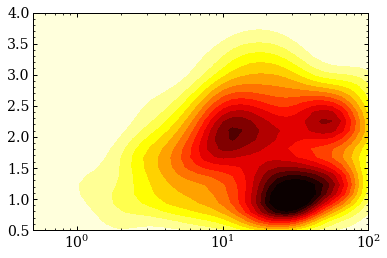

In [25]:
plt.contourf(Pgrid_arr, rpgrid_arr, fmapKDE.T, 18, cmap=plt.get_cmap('hot_r'),
             vmin=0, vmax=0.014)
plt.xscale('log')

## plot tois

In [26]:
savefigs = 0

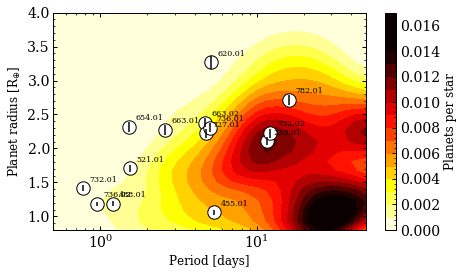

In [27]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

radval = 1
if radval:
    addlabel = 'radval'
    img = ax.contourf(Pgrid_arr, rpgrid_arr, fmapKDE.T, 18, cmap=plt.get_cmap('hot_r'), vmin=0, vmax=0.014)

    ax.errorbar(P, rpG, erpG, fmt='ko', ms=0)
    ax.scatter(P, rpG, facecolor='w', edgecolor='k', s=180, vmin=3000, vmax=3800)
    cbar = fig.colorbar(img)
    cbar.set_label('Planets per star', fontsize=12)

else:
    addlabel = ''
    ax.errorbar(P, rpG, erpG, fmt='ko', ms=0)
    img = ax.scatter(P, rpG, c=Teff, s=180, vmin=3000, vmax=3800)
    cbar = fig.colorbar(img)
    cbar.set_label('Teff [K]', fontsize=12)

for i in range(TOIs.size):
    if rpG[i]<4: ax.text(P[i]*1.1, rpG[i]+.1, TOIs[i], fontsize=8)

#ax.set_yscale('log'),
ax.set_ylim((.8,4))
ax.set_xscale('log'), ax.set_xlim((.5,50))
ax.set_xlabel('Period [days]', fontsize=12), ax.set_ylabel('Planet radius [R$_{\oplus}$]', fontsize=12)


if savefigs: plt.savefig('/Users/ryancloutier/Talks/HARPSNMeetings/Prp%s.png'%addlabel)

## get Vmag from colours 

V magnitudes are of interest for HARPS-N

In [28]:
# get colour relations from Pecaut + Mamajek
TeffPM,VJPM,VHPM,VKPM = np.loadtxt('asu.tsv', delimiter=';', skiprows=38, usecols=(1,2,3,4)).T

Vmag = np.zeros(N)
for i in range(N):
    g = abs(TeffPM - Teff[i]) == np.min(abs(TeffPM - Teff[i]))
    Vmag[i] = np.mean([VJPM[g]+Jmag[i], VHPM[g]+Hmag[i], VKPM[g]+Kmag[i]])

## compute sigmaRV and number of RVs to get 5 sigma masses

In [29]:
# spectrograph
computeNRV = 0
if computeNRV:
    prefix = 'tmptoi'
    Kdetsig = 5
    nRVmin = 10
    theta = 383, 690, 115e3, 3.6, .1, 1, .02, 0   # HARPS-N
    fname_spec = setup_spectrograph(prefix, *theta)

    # setup files and compute N_RV for all tois
    Ks, eKs, mps = np.zeros(N), np.zeros(N), np.zeros(N)
    sigRVs, sigeffs = np.zeros(N), np.zeros(N)
    nRVs, tobs = np.zeros(N), np.zeros(N)
    for i in range(N):
    
        print float(i)/N
    
        # setup star file
        theta = Vmag[i], MsG[i], RsG[i], Teff[i], 0, 1, 100
        fname_star = setup_star(prefix, *theta)
    
        # setup planet input file (example is GJ 1132 b)
        theta = P[i], rpG[i]
        fname_planet = setup_planet(prefix, *theta)

        # setup sigmaRV file
        texp = 10*60.   # sec
        sigact = 2.     # activity rms [m/s]
        sigplanets = 0. # planet rms [m/s]
        fname_sigRV = setup_sigRV(prefix, texp, sigact=sigact, sigplanets=sigplanets)

        # compute sigmaRV and nRV
        kwargs = {'input_planet_fname':fname_planet, 'input_star_fname':fname_star, 'input_spectrograph_fname':fname_spec,
                  'input_sigRV_fname':fname_sigRV, 'output_fname':'tmp', 'runGP':False, 'NGPtrials':0}
        self = nRV_calculator(Kdetsig, verbose_results=False, **kwargs)
        Ks[i], eKs[i], mps[i] = self.K, self.sigK_target, self.mp
        sigRVs[i], sigeffs[i] = self.sigRV_phot, self.sigRV_eff
    
        # pad nrv
        nRVs[i] = self.nRV if self.nRV > nRVmin else float(nRVmin)
        tobs[i] = nRVs[i]*texp/60.
        
    # save results
    p = np.array([TICs,TOIs,ra,dec,parG,eparG,Tmag,eTmag,Vmag,Jmag,eJmag,Hmag,eHmag,Kmag,eKmag,Teff,eTeff,distG,
                  edistG,MKG,eMKG,RsG,eRsG,MsG,eMsG,P,rpRs,rpG,erpG,Ks,eKs,mps,sigRVs,sigact,sigplanets,sigeffs,nRVs,
                  texp,tobs]).T
    #np.save('/Users/ryancloutier/Talks/HARPSNMeetings/cooltois_wNRV', p)
    
else:
    p = np.load('/Users/ryancloutier/Talks/HARPSNMeetings/cooltois_wNRV.npy', allow_pickle=True)
    TICs,TOIs,ra,dec,parG,eparG,Tmag,eTmag,Vmag,Jmag,eJmag,Hmag,eHmag,Kmag,eKmag,Teff,eTeff,distG,edistG,MKG,eMKG,RsG,eRsG,MsG,eMsG,P,rpRs,rpG,erpG,Ks,eKs,mps,sigRVs,sigact,sigplanets,sigeffs,nRVs,texp,tobs=p.T

## plot tois with N_RV

In [30]:
savefigs = 0

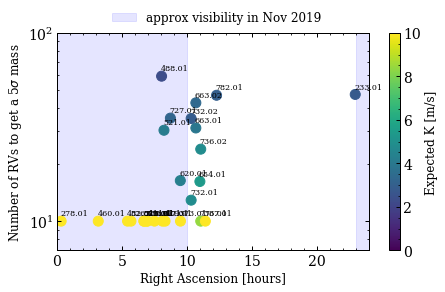

In [31]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
# highlight observable ra in November 2019 for HARPS-N
ramin, ramax = 23,10
if ramin < ramax:
    ax.fill_between([ramin,ramax], 1, 1e3, alpha=.1, color='b', label='approx visibility in Nov 2019')
else:
    ax.fill_between([ramin,24], 1, 1e3, alpha=.1, color='b', label='approx visibility in Nov 2019')
    ax.fill_between([0,ramax], 1, 1e3, alpha=.1, color='b')
    
# plot planets
img = ax.scatter(ra*24./360, nRVs, c=Ks, s=100, vmin=0, vmax=10)
cbar = fig.colorbar(img)
cbar.set_label('Expected K [m/s]', fontsize=12)

Nrvmax = 1e2
for i in range(N):
    if nRVs[i] < Nrvmax:
        ax.text(ra[i]*24/360.+1, nRVs[i]*1.1, TOIs[i], verticalalignment='center', 
                horizontalalignment='center', fontsize=8)

ax.set_yscale('log')
ax.set_ylim((7,Nrvmax)), ax.set_xlim((0,24))
ax.set_xlabel('Right Ascension [hours]', fontsize=12)
ax.set_ylabel('Number of RVs to get a 5$\sigma$ mass', fontsize=12)
plt.legend(bbox_to_anchor=(.88,1.15), fontsize=12)

if savefigs: plt.savefig('/Users/ryancloutier/Talks/HARPSNMeetings/raNRV.png')

In [32]:
data = np.array([TICs,TOIs,ra,dec,Vmag,distG,MsG,P,rpG,mps,Ks,sigeffs,nRVs]).T
s = np.argsort(TOIs)[::-1]
data = data[s]
cols = ['TIC','TOI','RA','Dec','Vmag','dist [pc]','Ms [Msun]','P [days]','rp [Rearth]','mp [Mearth]','K [m/s]',
        '$\sigma_{eff}$','N_RV']
df = pd.DataFrame(data, columns=cols)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,TIC,TOI,RA,Dec,Vmag,dist [pc],Ms [Msun],P [days],rp [Rearth],mp [Mearth],K [m/s],$\sigma_{eff}$,N_RV
0,429358906.0,782.01,183.921203,-18.910139,14.453333,52.589195,0.446120,16.047204,2.713368,6.805509,2.991429,2.888440,46.616461
1,219189765.0,737.01,171.014798,-19.556964,16.976667,302.141156,0.636580,1.732017,11.778316,109.331093,79.586829,6.617916,10.000000
2,181804752.0,736.02,165.691517,-16.406193,16.606667,26.512379,0.134957,0.947973,1.182739,1.931024,4.834382,3.357209,24.112645
3,181804752.0,736.01,165.691517,-16.406193,16.606667,26.516975,0.134986,4.990070,2.307447,5.853108,8.423702,3.357209,10.000000
4,36724087.0,732.02,154.646531,-11.716664,12.789000,21.997506,0.400806,12.254218,2.226559,5.664115,2.924030,2.449490,35.087920
5,36724087.0,732.01,154.646531,-11.716664,12.789000,21.992355,0.400691,0.768418,1.415356,3.708053,4.818276,2.449490,12.922243
6,149788158.0,727.01,130.736927,-2.498568,12.935000,43.025330,0.554919,4.726090,2.223264,5.654653,3.229122,2.711471,35.254215
7,54962195.0,663.02,160.065871,-8.511071,13.707000,64.352877,0.570121,4.698465,2.380388,6.025164,3.386685,3.122395,42.500692
8,54962195.0,663.01,160.065871,-8.511071,13.707000,64.346478,0.570339,2.598654,2.270886,5.768119,3.949808,3.122395,31.245939
9,35009898.0,654.01,164.724165,-5.546356,14.506000,57.845102,0.474794,1.527419,2.314816,5.871982,5.420559,3.089231,16.239875
